[0 1 2 3 4 5 6 7 8 9]
<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f5ab19b5570>>
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 6144)         620544      ['input_23[0][0]']               
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 100)       1000        ['input_

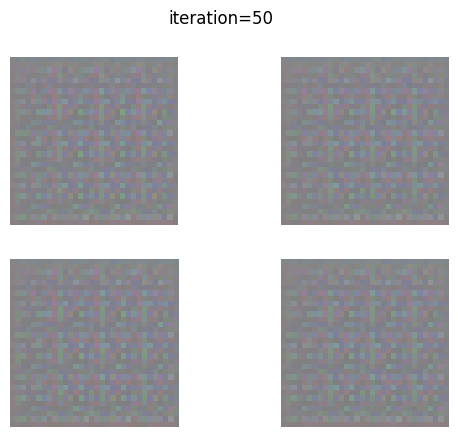

1/1 [==============================] - 0s 179ms/step


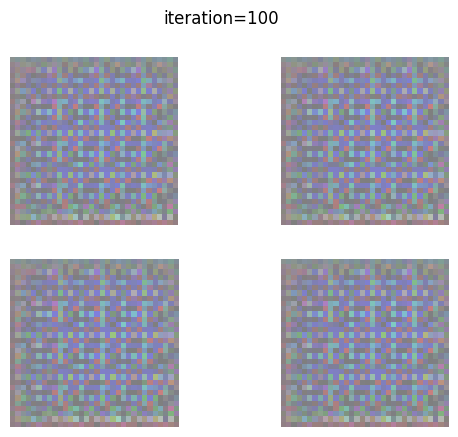

1/1 [==============================] - 0s 170ms/step


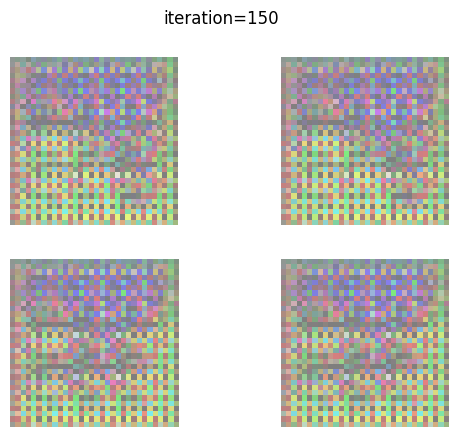

1/1 [==============================] - 0s 172ms/step


In [ ]:
import os
import cv2
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.applications.vgg16 import preprocess_input
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from matplotlib import pyplot
import numpy as np
from tensorflow.keras.layers import LeakyReLU
leaky_relu = LeakyReLU(alpha=0.01)
from tensorflow import keras


def load_data(path, type, shape):
      """
      load dataset
      """
      x = list()  # images
      y = list()  # images label

      images_name = os.listdir(path)
      for i, im in enumerate(images_name):
          filename = os.path.join(path, im)
          print(f'\rreading image :  {i + 1} / {len(images_name)}', end='')
          image = cv2.imread(filename)  # read image
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, shape)
          image =  preprocess_input(image)
          x.append(image)
          y.append(type)

      print()
      return x, np.array(y)


def real_data(train_path_covid,train_path_noncovid, shape):

      x_train_covid, y_train_covid = load_data(train_path_covid,'covide',shape)

      x_train_noncovid, y_train_noncovid = load_data(train_path_noncovid, 'noncovid',shape)

      images_train = np.vstack([x_train_noncovid, x_train_covid])
      target_images_train = np.hstack([y_train_noncovid, y_train_covid])

      le = LabelBinarizer()
      target_images_train=le.fit_transform(target_images_train)


      im_train = images_train.astype('float32')
      im_train = (im_train - 127.5) /127.5

      return images_train, target_images_train


def sampling_real_data(x, y, n_samples):
      """"'
      function for sampling images in the train model
      """""

      ix = randint(0, x.shape[0], n_samples)
      X, labels = x[ix], y[ix]

      y = np.ones((n_samples, 1))

      return [X, labels], y




def generate_noise(latent_dim, n_samples, mean,std):

      noise_0 = np.random.normal(mean[0], std[0], (n_samples//2, latent_dim))
      lb_0=zeros((n_samples//2))

      noise_1 = np.random.normal(mean[0], std[0], (n_samples//2, latent_dim))
      lb_1=np.ones((n_samples//2))

      noise=np.vstack([noise_0,noise_1])
      lb=np.hstack([lb_0,lb_1])

      idx = randint(0, (n_samples//2)*2, (n_samples//2)*2)

      noises=noise[idx]
      lb = (lb[idx]).reshape(-1,1)

      return [noises, lb]






def generate_fake_data(generator, latent_dim, n_samples,mean,std):

    noise_input, labels_input = generate_noise(latent_dim, n_samples,mean,std)

    images = generator.predict([noise_input, labels_input])

    y = zeros((n_samples, 1))
    return [images, labels_input], y









def define_discriminator(in_shape=(32,32,3),n_classes=10):
      # weight initialization
      init = RandomNormal(stddev=0.02)

      input_im = Input(shape=in_shape)
      #  downsampling
      conv = Conv2D(32, 3, strides=2, padding='same', kernel_initializer=init)(input_im)
      conv = LeakyReLU(alpha=0.2)(conv)
      conv = Dropout(0.5)(conv)

      conv = Conv2D(64, 3, padding='same', kernel_initializer=init)(conv)
      conv = BatchNormalization()(conv)
      conv = LeakyReLU(alpha=0.2)(conv)
      conv = Dropout(0.5)(conv)

      #  downsampling
      conv = Conv2D(128, 3, strides=(2,2), padding='same', kernel_initializer=init)(conv)
      conv = BatchNormalization()(conv)
      convt = LeakyReLU(alpha=0.2)(conv)
      conv = Dropout(0.5)(conv)

      conv = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(conv)
      conv = BatchNormalization()(conv)
      convt = LeakyReLU(alpha=0.2)(conv)
      conv = Dropout(0.5)(conv) # flatten feature maps
      conv = Flatten()(conv)

      out1 = Dense(1, activation='sigmoid')(conv)

      out2 = Dense(n_classes, activation='softmax')(conv)

      model = Model(input_im, [out1, out2],name='discriminator')

      opt = Adam(learning_rate=0.0005, beta_1=0.5)
      model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt,metrics=["accuracy"])
      print(model.summary)
      return model




def define_generator(latent_dim, n_classes=2):

      initializer= RandomNormal(stddev=0.02)

      #  embedding
      in_label = Input(shape=(1,))
      embed = Embedding(n_classes,100)(in_label)
      units = 4 * 4*1
      embed = Dense(units, kernel_initializer=initializer)(embed)
      reshape_embed = Reshape((4, 4, 1))(embed)

      latent_input = Input(shape=(latent_dim,))

      units = 384 * 4 * 4
      generator = Dense(units, kernel_initializer=initializer)(latent_input)
      generator = Activation(leaky_relu)(generator)
      generator = Reshape((4, 4, 384))(generator)

      merge = Concatenate()([generator, reshape_embed])

      #  upsampling
      generator = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=initializer)(merge)
      generator = BatchNormalization()(generator)
      generator = Activation(leaky_relu)(generator)

      # upsampling
      generator = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=initializer)(merge)
      generator = BatchNormalization()(generator)
      generator = Activation(leaky_relu)(generator)

      # upsampling
      generator = Conv2DTranspose(64,(5,5), strides=(2,2), padding='same', kernel_initializer=initializer)(generator)
      generator = BatchNormalization()(generator)
      generator = Activation(leaky_relu)(generator)

      # upsampling
      generator = Conv2DTranspose(32,(5,5), strides=(2,2), padding='same', kernel_initializer=initializer)(generator)
      generator = BatchNormalization()(generator)
      generator = Activation(leaky_relu)(generator)



      generator = Conv2D(3, (3, 3), activation=leaky_relu, padding='same')(generator)


      out_layer = Activation('tanh')(generator)

      model = Model([latent_input, in_label], out_layer,name='generator')
      print(model.summary())
      return model





def define_acgan(generator, discriminator):
      # fix discriminator
      discriminator.trainable = False

      gan_output = discriminator(generator.output)

      model = Model(generator.input, gan_output,name='ac_gan')

      opt = Adam(learning_rate=0.0002, beta_1=0.5)
      model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer = opt)

      return model




def plot_fake_image(itr,generator, latent_dim, n_samples=16,mean= [0,1],std=[.3,.3]):

      [ims_fake, _], _ =  generate_fake_data(generator, latent_dim, n_samples,mean,std) #generate fake image

      ims_fake = ((ims_fake + 1) / 2.0)

      for i in range(4):

          pyplot.subplot(2, 2, 1 + i)

          pyplot.axis('off')

          pyplot.imshow(ims_fake[i],cmap='gray') # plot fake image

      pyplot.suptitle(f'iteration={itr+1}')

      pyplot.show()



def train(generator, discriminator, ac_gan,im_train,trgt_train, latent_dim ,n_epochs, batch_size, mean, std):

    half_batch = int(batch_size / 2)
    for i in range(n_epochs):

        # train discriminator
        [im_real, target_real], y_real =  sampling_real_data(im_train,trgt_train, half_batch)
        discriminator.train_on_batch(im_real, [y_real, target_real])

        [im_fake, target_fake], y_fake =  generate_fake_data(generator, latent_dim, half_batch ,mean,std)
        discriminator.train_on_batch(im_fake, [y_fake, target_fake])


        [noise, lb_noise] = generate_noise(latent_dim, batch_size , mean, std)

        y_gan = ones((batch_size, 1))

        ac_gan.train_on_batch([noise, lb_noise], [y_gan, lb_noise])


        if (i+1) %  50 == 0:
            discriminator.evaluate(im_real, [y_real, target_real])

            ac_gan.evaluate([noise, lb_noise], [y_gan, lb_noise])

            plot_fake_image(i,generator, latent_dim, n_samples=16,mean=[-1,1],std=[.5,.5])



def main():
    (im_train, lb_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    print(np.unique(lb_train))
    resize_shape = (32,32)

    input_shape = (32,32,3)

    n_epochs = 15000
    batch_size = 32
    latent_dim = 100
    n_classes = 10
    mean= [0,1]
    std=[.3,.3]

    # train_path_covid = 'COVID,Non COVID-CT Images/train/COVID'
    # train_path_noncovid= 'COVID,Non COVID-CT Images/train/Non-COVID'
    # im_train,lb_train = real_data(train_path_covid,train_path_noncovid, shape=resize_shape)



      # im_train = np.load('/content/drive/MyDrive/model/images_train.npy')
      # lb_train = np.load('/content/drive/MyDrive/model/target_images_train.npy')
      # im_train = im_train.astype('float32')
      # im_train = (im_train - 127.5) / 127.5


    discriminator = define_discriminator(in_shape=input_shape,n_classes =  n_classes)

    generator = define_generator(latent_dim, n_classes=n_classes)

    ac_gan = define_acgan(generator, discriminator)

    train(generator, discriminator, ac_gan, im_train, lb_train, latent_dim , n_epochs=n_epochs, batch_size=batch_size, mean=mean, std=std)


    n_sample=400
    [im_fake, labels_fake], y_fake = generate_fake_data(generator, latent_dim, n_sample,mean=mean,std=std)

    np.save('im_fake.npy',im_fake)
    np.save('labels_fake.npy',labels_fake)
    print('data saved')

main()